In [1]:
# run this cell to clean up the variables 

%reset

In [2]:
import geopandas as gpd
from shapely.geometry import Polygon
import folium
from os.path import basename, splitext
import pandas as pd
from pyprojroot import here
import glob
import os
from pandas import DataFrame
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [3]:
here

<function pyprojroot.pyprojroot.here(relative_project_path='.', project_files=('.git', '.here', '*.Rproj', 'requirements.txt', 'setup.py', '.dvc', '.spyproject', 'pyproject.toml', '.idea', '.vscode'), warn=True) -> pathlib.Path>

In [4]:
#use pyprojroot for path with there here function, I can access my data all from the project root. This means if I move the notebook to another folder or subfolder I don't have to change the path to my data. Only if I move the data to another folder would I need to change the path in my notebook (or script)
file_path_metadata = here('./data/raw/ground_measures_metadata.csv')
file_path_train = here('./data/raw/ground_measures_train_features.csv')
file_path_test = here('./data/raw/ground_measures_test_features.csv')
file_path_train_labels = here('./data/raw/train_labels.csv')

In [5]:
file_path_train_labels

PosixPath('/Users/nicoleta/Desktop/code/Compare_SWE/data/raw/train_labels.csv')

In [6]:
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature  
from matplotlib import pyplot
#import rasterstats
import regionmask
import xarray as xr
#import xesmf as xe
import numpy as np
import pandas as pd
import dask.array as da
#import xoak

In [7]:
pd.read_csv(file_path_test)

,Unnamed: 0,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,CDEC:ADM,4.50,5.50,7.30,8.30,8.10,8.20,9.30,8.50,7.90,...,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDEC:AGP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDEC:ALP,12.72,13.78,17.12,18.07,18.17,18.38,17.71,16.05,14.62,...,3.34,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00
3,CDEC:BCB,12.20,12.20,13.30,13.35,12.85,12.72,12.72,12.80,13.16,...,15.44,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25
4,CDEC:BCH,6.60,5.76,5.16,7.68,4.68,1.32,0.84,0.84,0.24,...,0.12,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,6.80,12.50,13.10,14.40,16.30,19.10,19.80,19.80,19.70,...,6.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
696,SNOTEL:990_WA_SNTL,13.80,17.00,20.30,24.90,26.70,29.40,29.80,31.10,32.60,...,41.20,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00
697,SNOTEL:992_UT_SNTL,4.40,5.00,5.80,6.20,6.30,6.80,7.20,7.40,7.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
698,SNOTEL:998_WA_SNTL,37.90,47.00,51.80,61.90,69.00,73.40,77.30,81.40,83.60,...,96.00,95.10,95.50,94.20,94.20,NaN,75.10,70.40,58.70,35.10


In [8]:
#load metadata 
df_snotel_labels = pd.read_csv(file_path_train_labels)
df_snotel_labels

,cell_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-06-13,2019-06-14,2019-06-18,2019-06-24,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000ba8d9-d6d5-48da-84a2-1fa54951fae1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0017d1c4-64cb-426d-9158-3f6521d2dd22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0020c632-3d5c-4509-b4ee-6b63a89bf2ff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10873,ffdc53d2-5565-496a-b849-4fcf33f33a36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10874,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10875,ffe43514-2c92-43b6-bd84-d183806aca65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10876,fff95195-ccc9-40b7-b302-a0d8570c86bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_snotel_labels.set_index("cell_id", inplace=True)


In [10]:
df_train_labels = df_snotel_labels
one_station = df_train_labels.loc['0b9543d3-3cf9-4f28-b8eb-fd22c1956153']

<AxesSubplot: >

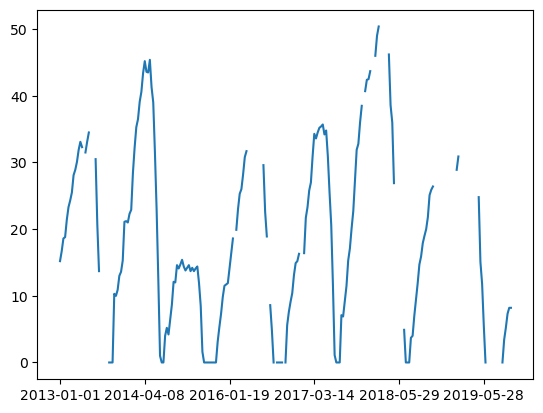

In [13]:
one_station.plot()

In [14]:
#load metadata 
df_snotel_md = pd.read_csv(file_path_metadata)
df_snotel_md

,station_id,name,elevation_m,latitude,longitude,state
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California
1,CDEC:AGP,Agnew Pass,2880.360000,37.726631,-119.141731,California
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California
3,CDEC:BCB,Blackcap Basin,3139.440000,37.066685,-118.773010,California
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California
...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,Moscow Mountain,1432.560059,46.805000,-116.853500,Idaho
696,SNOTEL:990_WA_SNTL,Beaver Pass,1106.423950,48.879299,-121.255501,Washington
697,SNOTEL:992_UT_SNTL,Bear River RS,2675.229492,40.885201,-110.827698,Utah
698,SNOTEL:998_WA_SNTL,Easy Pass,1606.296021,48.859329,-121.438950,Washington


In [15]:
#load train
df_snotel_train = pd.read_csv(file_path_train)
df_snotel_train.shape
#df_snotel_train

(700, 214)

In [16]:
#load test
df_snotel_test = pd.read_csv(file_path_test)
df_snotel_test.shape

(700, 58)

,cell_id,region,geometry
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,sierras,"POLYGON ((-118.71895 37.07419, -118.71895 37.0..."
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,central rockies,"POLYGON ((-107.07679 37.78042, -107.07679 37.7..."
2,000863e7-21e6-477d-b799-f5675c348627,other,"POLYGON ((-119.40167 37.02400, -119.40167 37.0..."
3,000ba8d9-d6d5-48da-84a2-1fa54951fae1,sierras,"POLYGON ((-119.32082 37.43171, -119.32082 37.4..."
4,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,sierras,"POLYGON ((-118.52132 36.65735, -118.52132 36.6..."
...,...,...,...
18125,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,sierras,"POLYGON ((-118.62014 37.11718, -118.62014 37.1..."
18126,ffe43514-2c92-43b6-bd84-d183806aca65,other,"POLYGON ((-123.49799 47.90132, -123.49799 47.9..."
18127,ffeabc13-7c6f-4b63-b043-19c8f15e0345,sierras,"POLYGON ((-119.64422 37.87976, -119.64422 37.8..."
18128,fff95195-ccc9-40b7-b302-a0d8570c86bc,other,"POLYGON ((-123.37223 47.73242, -123.37223 47.7..."


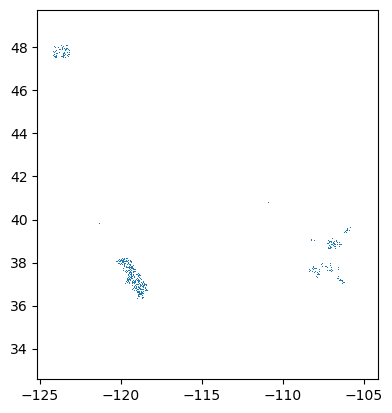

In [17]:
df_grid = gpd.read_file(here('./data/raw/grid_cells.geojson'))
df_grid['geometry']
df_grid.plot()
df_grid

In [18]:
m = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles='CartoDB positron')
for _, r in df_grid.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
   # folium.Popup(r['BoroName']).add_to(geo_j)
    geo_j.add_to(m)
#

In [19]:
n = folium.Map(
    location = [40.715, -108.565],
    zoom_start = 12,
    tiles = 'Stamen Terrain'
)

#folium.GeoJson(osse_poly).add_to(m)
#folium.LatLngPopup().add_to(n)
tooltip = 'Click me!'
#n.choropleth(geo_path="/Users/carina/Desktop/code/SEUP/grid_cells.geojson")
#n.choropleth(geo_path='/Users/carina/Desktop/code/SEUP/grid_cells.geojson', topojson="objects.nyct2010")

df_snotel_ml.apply(lambda row:folium.CircleMarker(location=[row["latitude"], 
                                                  row["longitude"]]).add_to(n),
     axis=1)

from folium.features import DivIcon
#n

NameError: name 'df_snotel_ml' is not defined

In [88]:
#extract UA data at points

path_ua = '/Users/nicoleta/Desktop/data/UA_SWE/'
files_ua = path_ua + '4km_SWE_Depth*.nc'
ds_ua = xr.open_mfdataset(files_ua)

In [19]:
#import os
#ROOT_DIR = os.path.realpath(os.path.join(os.path.dirname(__file__), '..'))

In [23]:
#extract SNODAS data at points 
#path_snodas = '/Users/carina/Desktop/data/seup/SNODAS_SWE_year/'
#ds_SNODAS = xr.open_mfdataset(path_snodas +'*.nc')


OSError: no files to open

In [89]:
centroids = np.vstack(df_grid.geometry.centroid).T
lon_grid = centroids[0:1].ravel().tolist()
lat_grid = centroids[1:2].ravel().tolist()


/var/folders/cj/b1yrjqfd1kj1xd6tryxsg1_r0000gn/T/ipykernel_55123/3621146035.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.vstack(df_grid.geometry.centroid).T
<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


In [94]:
grid_labels = df_grid['cell_id'].to_numpy()

In [95]:
grid_labels = grid_labels.ravel().tolist()


In [96]:
dataUA_grid  = ds_ua.sel(lon = lon_grid, lat = lat_grid, method='nearest')

#dataSNODAS_grid = ds_SNODAS.sel(lon = lon_grid, lat = lat_grid, method='nearest')
#ts_dataframe = data[vars].to_dataframe()

/opt/homebrew/Caskroom/miniforge/base/envs/compare_swe/lib/python3.9/site-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [97]:
dataUA_grid

<xarray.Dataset>
Dimensions:   (time: 3287, lat: 18130, lon: 18130, time_str_len: 11)
Coordinates:
  * lat       (lat) float32 37.08 37.79 37.04 37.42 ... 47.92 37.88 47.75 47.54
  * lon       (lon) float32 -118.7 -107.1 -119.4 -119.3 ... -119.7 -123.4 -123.8
  * time      (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2021-09-30
Dimensions without coordinates: time_str_len
Data variables:
    crs       (time) |S1 b'' b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    time_str  (time_str_len, time) |S1 dask.array<chunksize=(11, 365), meta=np.ndarray>
    SWE       (time, lat, lon) float32 dask.array<chunksize=(365, 18130, 18130), meta=np.ndarray>
    DEPTH     (time, lat, lon) float32 dask.array<chunksize=(365, 18130, 18130), meta=np.ndarray>

In [98]:
dataUA_grid_label = dataUA_grid.assign_coords(label = grid_labels) 

#dataSNODAS_grid_label = dataSNODAS_grid.assign_coords(label = grid_labels)

In [99]:
#one_point = dataUA_grid_label.sel(lat = 37.083332, lon = -118.708336,  method='nearest')
#one_point.SWE.plot()
#one_point

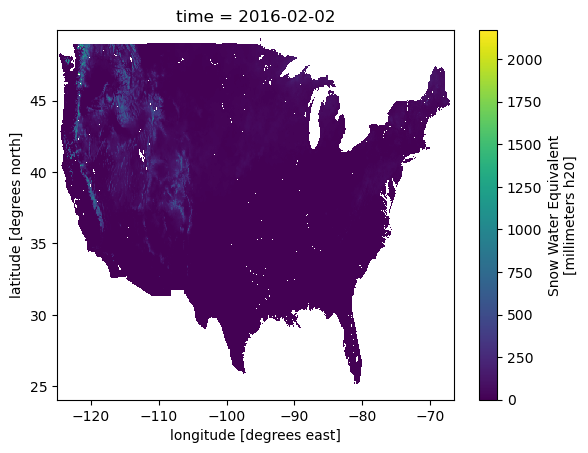

In [100]:
SWE_UA = ds_ua.SWE.sel(time = '2016-02-02')
im = SWE_UA.plot()

In [101]:
#df_ua = pd.DataFrame(columns = ['date', 'SWE_UA', 'snowdepth_UA' 'cell_id', 'latitude', 'longitude'])

In [150]:
import xarray as xr

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

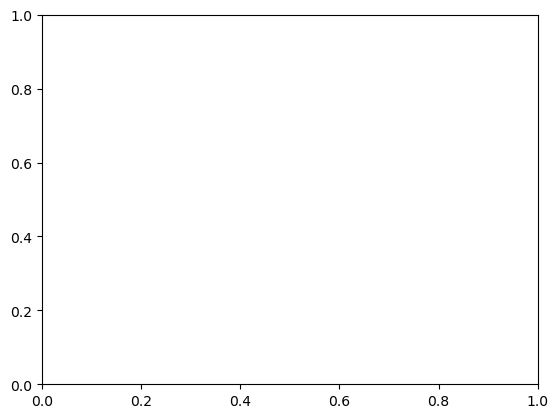

In [169]:
dataUA_grid = xr.open_dataset('/Users/nicoleta/Desktop/code/SEUP/SWE_UA_GRID_.nc')
#dataUA_grid.SWE.sel(time = '2016-02-02').plot()

In [167]:
dataUA_grid_point

<xarray.Dataset>
Dimensions:   (lat: 441, lon: 316, time: 1826, time_str_len: 11)
Coordinates:
  * lat       (lat) float32 37.08 37.08 37.08 37.08 ... 37.08 37.08 37.08 37.08
  * lon       (lon) float32 -118.7 -118.7 -118.7 -118.7 ... -118.7 -118.7 -118.7
  * time      (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2017-09-30
Dimensions without coordinates: time_str_len
Data variables:
    crs       (time) |S1 ...
    time_str  (time_str_len, time) |S1 ...
    SWE       (time, lat, lon) float32 ...
    DEPTH     (time, lat, lon) float32 ...

In [165]:
dataUA_grid_point  = dataUA_grid.sel(lon = -106.68000, lat = 40.54000,  method='nearest')
dataUA_grid_point
#dataUA_grid_point['SWE'].plot()
#test_ua['SWE'][:,1000,1000].plot()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [160]:
dataUA_point  = dataUA_grid.sel(lon = -118.708336, lat = 37.083332, method='nearest')
dataUA_point['SWE'].plot()
#test_ua['SWE'][:,1000,1000].plot()
dataUA_point['SWE']

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [166]:
dataUA_point

NameError: name 'dataUA_point' is not defined

In [110]:
#t = dataUA_point.to_dataframe()
t = ds_ua.sel(lon = -118.708336, lat = 37.083332, method='nearest').to_dataframe()
t

crs        lat         lon time_str  SWE  DEPTH
time       time_str_len                                                 
2012-10-01 0             b''  37.083332 -118.708336     b'0'  0.0    0.0
           1             b''  37.083332 -118.708336     b'1'  0.0    0.0
           2             b''  37.083332 -118.708336     b'-'  0.0    0.0
           3             b''  37.083332 -118.708336     b'O'  0.0    0.0
           4             b''  37.083332 -118.708336     b'c'  0.0    0.0
...                      ...        ...         ...      ...  ...    ...
2021-09-30 6             b''  37.083332 -118.708336     b'-'  0.0    0.0
           7             b''  37.083332 -118.708336     b'2'  0.0    0.0
           8             b''  37.083332 -118.708336     b'0'  0.0    0.0
           9             b''  37.083332 -118.708336     b'2'  0.0    0.0
           10            b''  37.083332 -118.708336     b'1'  0.0    0.0

[36157 rows x 6 columns]

In [111]:
#t.drop([ 'crs', 'time_str'], axis=1)
#t.head()

In [112]:
#t.head()

In [113]:
#df_ua = pd.DataFrame(columns = ['date', 'SWE_UA', 'snowdepth_UA' 'cell_id', 'latitude', 'longitude'])
df = pd.DataFrame(columns = ['date',  'SWE_UA', 'latitude', 'longitude'])
#df_ = pd.DataFrame(columns = ['latitude', 'longitude'])

In [114]:
lon_grid_ = lon_grid[0:2]
lon_grid_
    

[-118.7234447492404, -107.08127866705138]

In [115]:
df_list = list()

#def sample_at_points(lat_grid, lon_grid):
for (i, j, k) in zip(lon_grid[0:5], lat_grid[0:5], grid_labels[0:5]):
    df = pd.DataFrame(columns = ['date',  'SWE_UA', 'Depth_UA','latitude', 'longitude','label'])
    dataUA_point  = ds_ua.sel(lon = i , lat = j, method='nearest')                             
    df['date'] = dataUA_point.time.values
    #df['cell_id'] = current_cell_id
    df['longitude'] = i #dataUA_point.lon_grid.values
    df['latitude'] = j #dataUA_point.lat_grid.values
    df['SWE_UA'] = dataUA_point.SWE.values
    df['Depth_UA'] = dataUA_point.DEPTH.values
    df['label'] = k
    #print(df)
    df_list.append(df)
    df_ua = pd.concat(df_list) 

In [116]:
df_ua#df_ua.to_csv('single_csv_file.csv')

,date,SWE_UA,Depth_UA,latitude,longitude,label
0,2012-10-01,0.0,0.0,37.077776,-118.723445,0003f387-71c4-48f6-b2b0-d853bd4f0aba
1,2012-10-02,0.0,0.0,37.077776,-118.723445,0003f387-71c4-48f6-b2b0-d853bd4f0aba
2,2012-10-03,0.0,0.0,37.077776,-118.723445,0003f387-71c4-48f6-b2b0-d853bd4f0aba
3,2012-10-04,0.0,0.0,37.077776,-118.723445,0003f387-71c4-48f6-b2b0-d853bd4f0aba
4,2012-10-05,0.0,0.0,37.077776,-118.723445,0003f387-71c4-48f6-b2b0-d853bd4f0aba
...,...,...,...,...,...,...
3282,2021-09-26,0.0,0.0,36.660957,-118.525815,00146204-d4e9-4cd8-8f86-d1ef133c5b6d
3283,2021-09-27,0.0,0.0,36.660957,-118.525815,00146204-d4e9-4cd8-8f86-d1ef133c5b6d
3284,2021-09-28,0.0,0.0,36.660957,-118.525815,00146204-d4e9-4cd8-8f86-d1ef133c5b6d
3285,2021-09-29,0.0,0.0,36.660957,-118.525815,00146204-d4e9-4cd8-8f86-d1ef133c5b6d


In [120]:
#def sample_at_points(lat_grid, lon_grid):
df_year = ()

for (i, j, k) in zip(lon_grid[0:5], lat_grid[0:5], grid_labels):
    df = pd.DataFrame(columns = ['date',  'SWE_UA', 'Depth_UA','latitude', 'longitude','label'])
    dataUA_point  = ds_ua.sel(lon = i , lat = j, method='nearest')                             
    df['date'] = dataUA_point.time.values
    df['longitude'] = i #dataUA_point.lon_grid.values
    df['latitude'] = j #dataUA_point.lat_grid.values
    df['SWE_UA'] = dataUA_point.SWE.values
    df['Depth_UA'] = dataUA_point.DEPTH.values
    df['label'] = k
    df = df.set_index(pd.DatetimeIndex(df['date']))
    cols = ["SWE_UA","Depth_UA"]
    df[cols] = df[cols].replace(['0', 0], np.nan)
    df_list.append(df_year)
    #print(df)
    
    #df_year = pd.DataFrame(columns = ['SWE_UA', 'Depth_UA','latitude', 'longitude','label'])
    #df_year['SWE_UA'] = df['SWE_UA'].mean() 
    #print(df_year)
    #df_year['SWE_UA'] = df['Depth_UA'].mean() 
    #df_year['lat'] = df['latitude'].agg(mean_str)
    #df_year['long'] = df['longitude'].agg(mean_str)
    #df_year['label'] = df['label'].agg(mean_str)
    
    #print(df_year)
   
    #df_ua_year = pd.concat(df_list) 

#save to file 
#df_ua_yearly.to_csv('us_grid_yearly.csv')



In [121]:
df_list_year = list()

for df in df_list:
    #print(df)
    #df_year = pd.DataFrame(columns = ['SWE_UA', 'Depth_UA','lat', 'long','label'])
    temp1 = df['SWE_UA'].mean() 
    df_year['SWE_UA'] = temp1
   # print(df_year)
    #df_year['SWE_UA'] = df['SWE_UA'].mean() 
    #df_year['SWE_UA'] = df['Depth_UA'].mean() 
    temp2 = df['Depth_UA'].mean()
    df_year['Depth_UA'] = temp2
    df_year['lat'] = df['latitude'].mean()
    df_year['long'] = df['longitude'].agg(mean_str)
    df_year['label'] = df['label'].agg(mean_str)
    print(df_year)
    #df_list_year.append(df_year)
    #df_ua_year = pd.concat(df_list_year)
    

TypeError: 'tuple' object does not support item assignment

In [408]:

df_year.to_csv('df_year.csv')

In [122]:
df_list_year

[]

In [123]:
#df_year['SWE_UA'] = df['SWE_UA'].mean() 
temp = df['SWE_UA'].mean()
df_year['SWE_UA'] = temp

TypeError: 'tuple' object does not support item assignment

In [124]:
df_year

()

In [125]:
test = df.mean() 
test

/var/folders/cj/b1yrjqfd1kj1xd6tryxsg1_r0000gn/T/ipykernel_55123/2754669023.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  test = df.mean()
/var/folders/cj/b1yrjqfd1kj1xd6tryxsg1_r0000gn/T/ipykernel_55123/2754669023.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test = df.mean()


SWE_UA       323.549744
Depth_UA     967.211731
latitude      37.077776
longitude   -118.723445
dtype: float64

In [126]:
df_year['SWE_UA'] = df['SWE_UA'].mean()

TypeError: 'tuple' object does not support item assignment

In [127]:
df_year['SWE_UA'] = df['SWE_UA'].mean() 
df_year['Depth_UA'] = df['Depth_UA'].mean() 
df_year['lat'] = df['latitude'].agg(mean_str)
df_year['long'] = df['longitude'].agg(mean_str)
df_year['label'] = df['label'].agg(mean_str)

TypeError: 'tuple' object does not support item assignment

In [128]:
#df
df_year
#dataUA_point_sel  = ds_ua.sel(lon_grid[0], lat_grid[0])

()

In [129]:
df_ua_year.to_csv('df_ua_year.csv')

NameError: name 'df_ua_year' is not defined

In [130]:
from pandas.api.types import is_numeric_dtype

def mean_str(col):
    if is_numeric_dtype(col):
        return col.mean()
    else:
        return col.unique() if col.nunique() == 1 else np.NaN
test = df['label'].agg(mean_str)

In [131]:
test = df.agg(mean_str)

In [132]:
test

date                                            NaN
SWE_UA                                   323.549744
Depth_UA                                 967.211731
latitude                                  37.077776
longitude                               -118.723445
label        [0003f387-71c4-48f6-b2b0-d853bd4f0aba]
dtype: object

<AxesSubplot: >

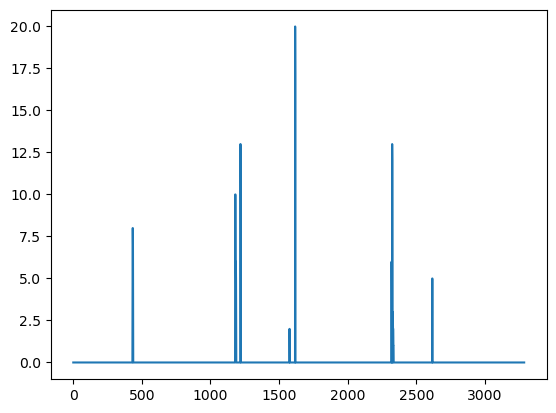

In [133]:
test = df_list[2]
test['SWE_UA'].plot()

<AxesSubplot: >

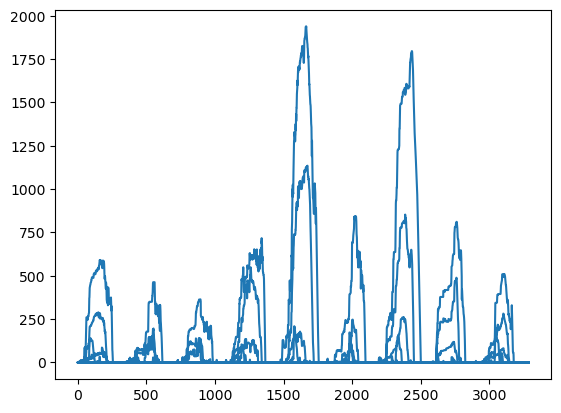

In [134]:
df_ua['SWE_UA'].plot()

<AxesSubplot: >

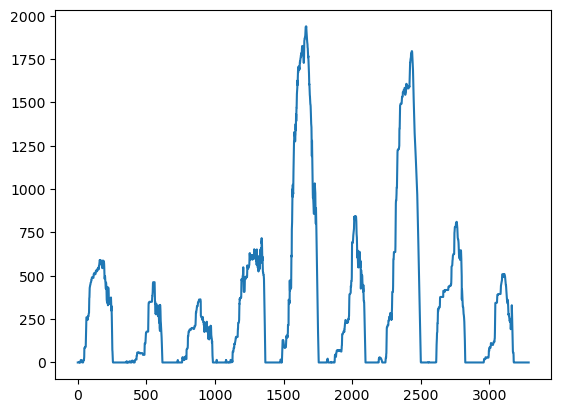

In [135]:
df['SWE_UA'].plot()

<AxesSubplot: xlabel='date'>

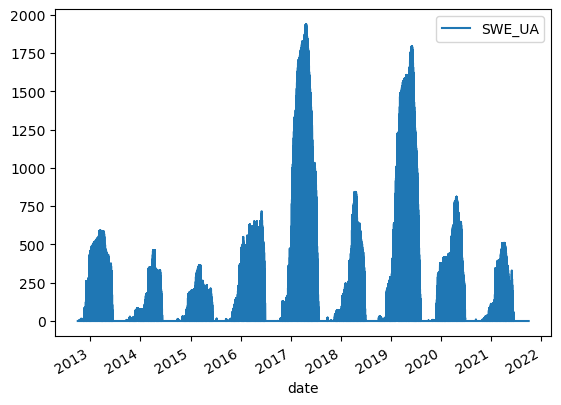

In [136]:
df_ua.plot(x = 'date', y = 'SWE_UA')

In [137]:
us_grid = pd.read_csv('/Users/carina/Desktop/code/Processing_tools/us_grid.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/carina/Desktop/code/Processing_tools/us_grid.csv'

In [138]:
us_grid

NameError: name 'us_grid' is not defined

In [139]:
us_grid.set_index("label", inplace=True)
us_grid.head()

NameError: name 'us_grid' is not defined

In [140]:
test = us_grid.loc['76b55900-eb3d-4d25-a538-f74302ffe72d']

NameError: name 'us_grid' is not defined

<AxesSubplot: xlabel='date'>

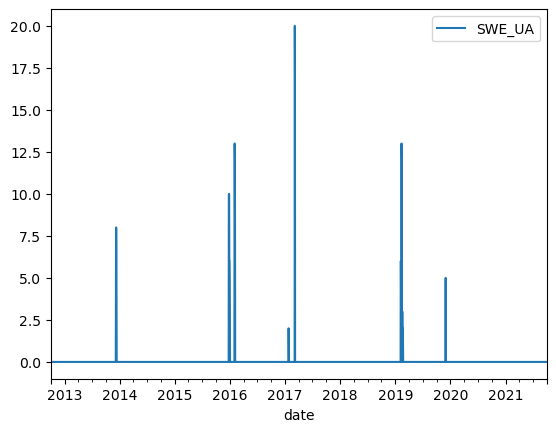

In [141]:
test.plot(x = 'date', y = 'SWE_UA')

In [142]:
us_grid_station = pd.read_csv('/Users/carina/Downloads/station_cell_mapping.txt')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/carina/Downloads/station_cell_mapping.txt'

In [143]:
us_grid_station.set_index("cell_id", inplace=True)
us_grid_station.head()

NameError: name 'us_grid_station' is not defined

In [144]:
test_station = us_grid_station.loc['76b55900-eb3d-4d25-a538-f74302ffe72d']

NameError: name 'us_grid_station' is not defined

In [145]:
test_station.plot(x = 'date', y = 'SWE_UA')

NameError: name 'test_station' is not defined